# Task
Apply the tools of machine learning to predict which passengers of the Titanic survived the tragedy.  For each PassengerId in the test set, you must predict a 0 or 1 value for the Survived variable.  Your score is the percentage of passengers you correctly predict (accuracy).

# Setup
Import packages necessary for data manipulation and vizualization.

## Packages for handling table-like data and matricies

In [57]:
import numpy as np
import pandas as pd

## Packages for modelling algorithms

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

## Packages for modelling helpers

In [59]:
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

## Packages for data vizualization

In [60]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

### Configure visualizations

In [61]:
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## Helper functions provided by Helge Bjorland & Stian Eide

In [62]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

## Import data and create data frames

In [63]:
train = pd.read_csv("/home/onenonlykpro/Downloads/train.csv")
test = pd.read_csv("/home/onenonlykpro/Downloads/test.csv")

full = train.append( test , ignore_index = True )
titanic = full[ :891 ]

del train , test

print ('Datasets:' , 'full:' , full.shape , 'titanic:' , titanic.shape)

Datasets: full: (1309, 12) titanic: (891, 12)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


## Quickly examine and get understanding of data
- Survived: Survived (1) or died (0)
- Pclass: Passenger's class
- Name: Passenger's name
- Sex: Passenger's sex
- Age: Passenger's age
- SibSp: Number of siblings/spouses aboard
- Parch: Number of parents/children aboard
- Ticket: Ticket number
- Fare: Fare
- Cabin: Cabin
- Embarked: Port of embarkation
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton

In [66]:
titanic.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [67]:
titanic.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.381594,446.000000,2.308642,0.523008,0.383838
std,14.526497,49.693429,0.806057,257.353842,0.836071,1.102743,0.486592
min,0.420000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,223.500000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,446.000000,3.000000,0.000000,0.000000
75%,38.000000,31.000000,0.000000,668.500000,3.000000,1.000000,1.000000
max,80.000000,512.329200,6.000000,891.000000,3.000000,8.000000,1.000000


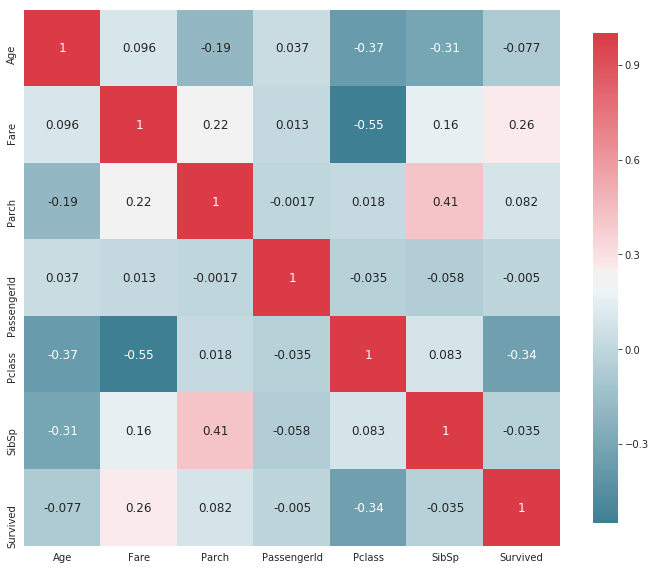

In [68]:
plot_correlation_map( titanic )

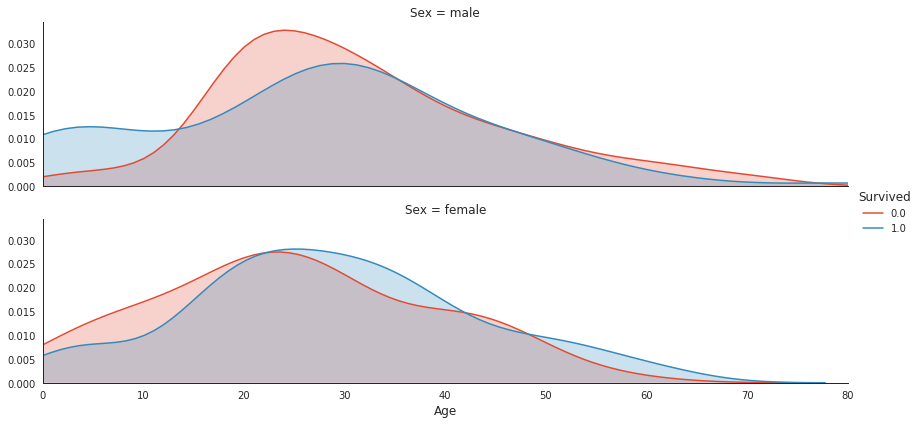

In [69]:
plot_distribution( titanic , var = 'Age' , target = 'Survived' , row = 'Sex' )

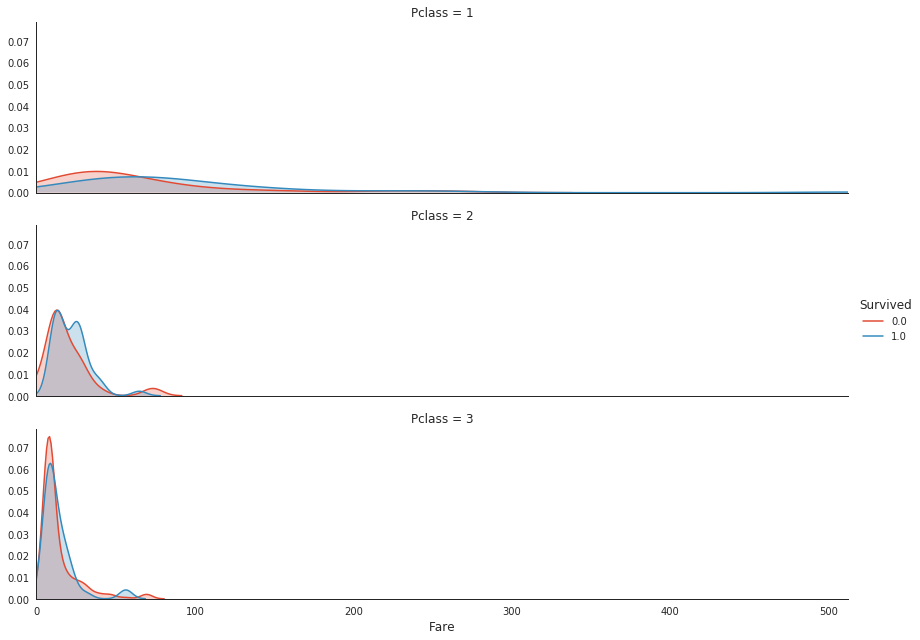

In [70]:
plot_distribution( titanic , var = 'Fare' , target = 'Survived' , row = 'Pclass' )

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


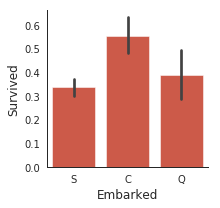

In [71]:
plot_categories( titanic , cat = 'Embarked' , target = 'Survived' )

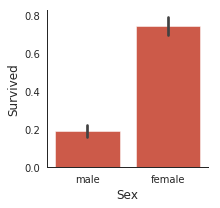

In [72]:
plot_categories( titanic , cat = 'Sex' , target = 'Survived' )

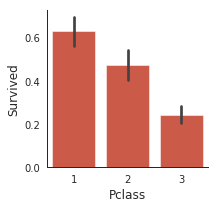

In [73]:
plot_categories( titanic , cat = 'Pclass' , target = 'Survived' )

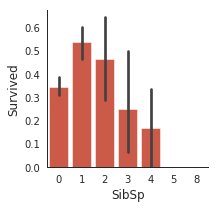

In [74]:
plot_categories( titanic , cat = 'SibSp' , target = 'Survived' )

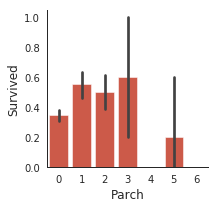

In [75]:
plot_categories( titanic , cat = 'Parch' , target = 'Survived' )

## Data cleaning
Categorical variables need to be transformed to numeric variables.  First, transform Sex into binary values 0 and 1.

In [76]:
sex = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

Second, create a new variable for every unique value of Embarked

In [77]:
embarked = pd.get_dummies( full.Embarked , prefix = 'Embarked' )
embarked.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


Third, create a new variable for every unique value of Pclass

In [78]:
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


Most machine learning alghorims require all variables to have values in order to use it for training the model. The simplest method is to fill missing values with the average of the variable across all observations in the training set.

In [79]:
imputed = pd.DataFrame()
imputed[ 'Age' ] = full.Age.fillna( full.Age.mean() )
imputed[ 'Fare' ] = full.Fare.fillna( full.Fare.mean() )
imputed[ 'Parch' ] = full.Parch.fillna( full.Parch.mean() )
imputed[ 'SibSp' ] = full.SibSp.fillna( full.SibSp.mean() )
imputed.head()

,Age,Fare,Parch,SibSp
0,22.0,7.2500,0,1
1,38.0,71.2833,0,1
2,26.0,7.9250,0,0
3,35.0,53.1000,0,1
4,35.0,8.0500,0,0


Each passenger appeared to come with a title (ex. "Ms", Sir", "Mr", etc.). Titles reflect social status and may predict survival probability. Extract the title from each name and use a map of more aggregated titles (provided by http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html).

In [80]:
title = pd.DataFrame()
title[ 'Title' ] = full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"
                    }
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title )
title.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


Cabin categories might also provide some additional insight for the prediction modeling. Extract Cabin category information from the Cabin number.

In [81]:
cabin = pd.DataFrame()
cabin[ 'Cabin' ] = full.Cabin.fillna( 'U' ) # Replaces missing cabins with 'U' for Unknown
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )
cabin.head()

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


Same with ticket class found in the ticket number. Extract ticket class from ticket number.

In [82]:
# Create function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )
ticket.shape
ticket.head()

,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Predictive model variable selection
Select which features/variables to include in the dataset.

In [83]:
full_X = pd.concat( [ imputed , embarked , cabin , sex ] , axis = 1 )
full_X.head()

,Age,Fare,Parch,SibSp,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Sex
0,22.0,7.2500,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1
1,38.0,71.2833,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0
2,26.0,7.9250,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,35.0,53.1000,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
4,35.0,8.0500,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


In [84]:
train_valid_X = full_X[ 0:891 ]
train_valid_y = titanic.Survived
test_X = full_X[ 891: ]
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )
print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)

(1309, 17) (623, 17) (268, 17) (623,) (268,) (418, 17)


/home/onenonlykpro/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.9903691813804173


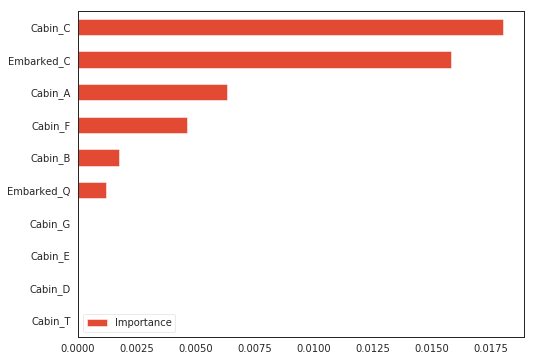

In [85]:
plot_variable_importance(train_X, train_y)

# Modeling
## Choose predictive models
Use the training dataset to train several predictive models, which will be evaluated later.

In [103]:
model = RandomForestClassifier(n_estimators = 100) #Random Forests Model
# model = SVC() #Support Vector Machines
# model = GradientBoostingClassifier() #Gradient Boosting Classifier
# model = KNeighborsClassifier(n_neighbors = 3) #K-nearest neighbors
# model = GaussianNB() #Gaussian Naive Bayes
# model = LogisticRegression() #Logistic Regression

## Train the model
When you have selected a dataset with the features you want and a model you would like to try it is now time to train the model. 

In [104]:
model.fit( train_X , train_y )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Model evaluation
Evaluate the accuracy of the model by using the validation set where we know the actual outcome. This data set have not been used for training the model, so it's completely new to the model. We then compare this accuracy score with the accuracy when using the model on the training data. If the difference between these are significant this is an indication of overfitting. We try to avoid this because it means the model will not generalize well to new data and is expected to perform poorly.

In [105]:
print (" Accuracy of the model on the training sets is: ", model.score( train_X , train_y ), "\n",
       "Accuracy of the model on the real-world sets is: ", model.score( valid_X , valid_y ))

 Accuracy of the model on the training sets is:  0.9903691813804173 
 Accuracy of the model on the real-world sets is:  0.7761194029850746


## Print predictions
After selecting the most accurate model, print and export the predicted results.

In [106]:
test_Y = model.predict( test_X )
passenger_id = full[891:].PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': test_Y } )
test.shape
test.head()

,PassengerId,Survived
891,892,0.0
892,893,0.0
893,894,0.0
894,895,1.0
895,896,1.0


In [107]:
test.to_csv( 'titanic_pred.csv' , index = False )